In [1]:
from helpers import get_client, get_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

sns.set_style('whitegrid')
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator

In [2]:
es = get_client()  
down_lat = get_data("aggregated-curr-dlping-*", es)
up_lat   = get_data("aggregated-curr-ulping-*", es)

for df in (down_lat, up_lat):
    df['date'] = pd.to_datetime(df['date'])

Connected to Elasticsearch.


In [3]:
print(down_lat.head())

   unit_id operator_name operator_technology  adv_download_speed  \
0     1256          AT&T                 DSL                 6.0   
1     9986    Windstream                 DSL                12.0   
2     7940         Qwest                 DSL                 1.5   
3     8472       Verizon                 DSL                 3.0   
4     1237    TimeWarner               Cable                10.0   

   adv_upload_speed     rtt_avg     rtt_max    rtt_min     rtt_std  \
0             0.768  320.446142  509.070650  16.295039  142.201427   
1             0.768   83.029509  126.675788  24.775956   27.500483   
2             0.896  593.593058  887.653413  68.992001  271.727568   
3             0.768  170.722409  398.502439  51.488102  135.453667   
4             1.000   33.201839   59.520883  25.038274    9.827856   

                       date  
0 2011-02-01 00:00:00+00:00  
1 2011-03-01 00:00:00+00:00  
2 2011-04-01 00:00:00+00:00  
3 2011-05-01 00:00:00+00:00  
4 2011-06-01 00:00:0

In [ ]:
def plot_rtt_percentiles_jan_to_jul(df, type):
    """
    Given a DataFrame with 'date', 'rtt_avg' and 'operator_technology' columns,
    filters to data from 2023 and months January–July, then plots a 2×2 grid
    (overall, Cable, DSL, Fiber) of the 99th, 95th, and 75th percentiles of rtt_avg.
    """
    # Make a copy and ensure datetime
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Filter to year 2023
    df2023 = df[df['date'].dt.year == 2023].copy()
    if df2023.empty:
        raise ValueError("No data for year 2023.")
    
    # Extract month and keep only months 1–7 (because of the 2023 data)
    df2023['month'] = df2023['date'].dt.month
    df2023 = df2023[df2023['month'].between(1, 7)]
    if df2023.empty:
        raise ValueError("No data in months January–July 2023.")

    # Percentiles & styling
    pct = [0.99, 0.95, 0.75]
    labels = {0.99: '99th', 0.95: '95th', 0.75: '75th'}
    colors = {'99th': 'tab:blue', '95th': 'tab:orange', '75th': 'tab:green'}

    # Prepare subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    titles = ['Overall', 'Cable', 'DSL', 'Fiber']
    techs  = [None,      'Cable', 'DSL', 'Fiber']

    for ax, title, tech in zip(axes, titles, techs):
        sub = df2023 if tech is None else df2023[df2023['operator_technology'] == tech]

        # Group & percentile calc
        grp = sub.groupby('month')['rtt_avg']
        stats = grp.quantile(pct).unstack(level=1)

        # Plot each percentile
        for q in pct:
            if q in stats.columns:
                ax.plot(
                    stats.index,
                    stats[q],
                    label=labels[q],
                    color=colors[labels[q]],
                    marker='o'
                )
        ax.set_title(title)
        ax.set_xticks(range(1, 8))
        ax.set_xticklabels(calendar.month_abbr[1:8])

        if type == 'download':
            ax.yaxis.set_major_locator(MultipleLocator(100))

    # Figure‐wide settings
    fig.supxlabel('Month')
    fig.supylabel('RTT Avg (ms)')
    fig.suptitle(f'Low Performance Latency Percentiles ({type.capitalize()}) [01/2023 - 07/2023]', fontsize=16, y=0.95)

    # Shared legend
    lines = [plt.Line2D([], [], color=colors[labels[q]], marker='o') for q in pct]
    labels  = [f'{int(p*100)}th percentile' if p>0 else f'{p}st percentile' for p in pct]
    fig.legend(lines, labels, loc='upper right', ncol=1, bbox_to_anchor=(0.98, 0.98))

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(f'./plots/low_perf_quartiles/lul_{type}.png', dpi=600)
    plt.show()


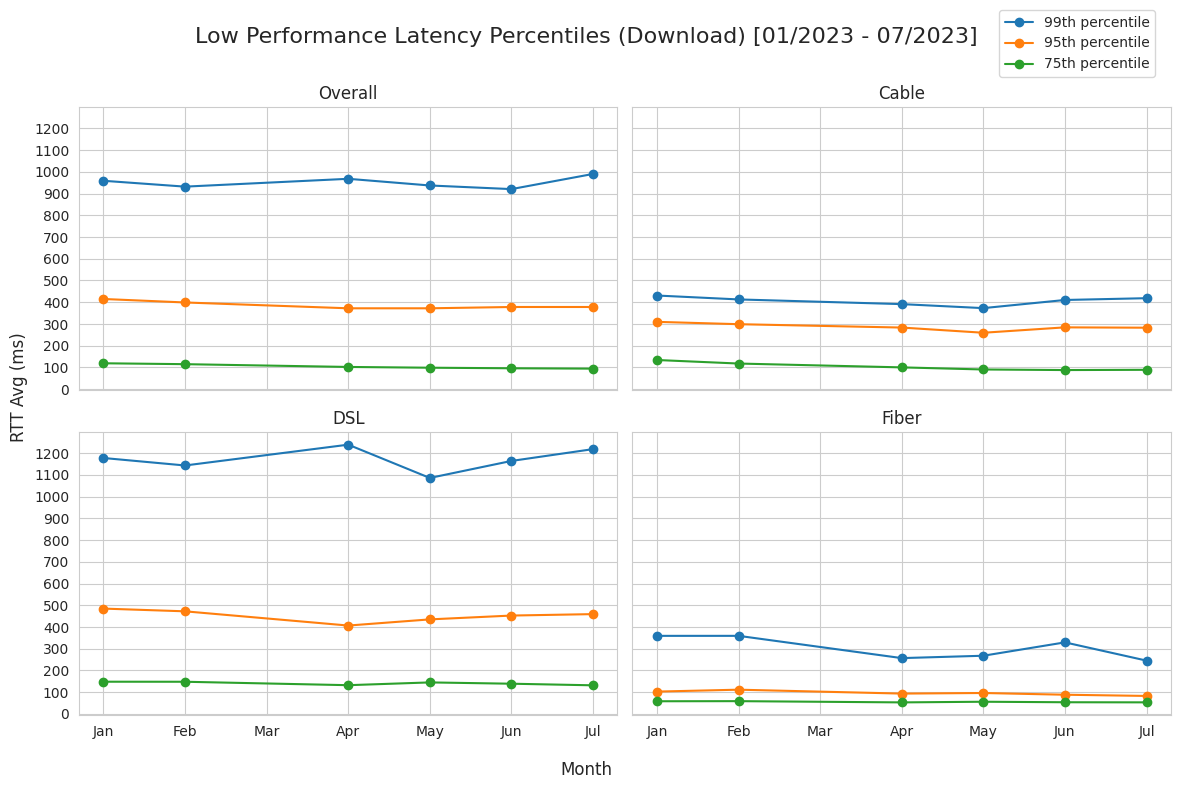

In [7]:
plot_rtt_percentiles_jan_to_jul(down_lat, 'download')

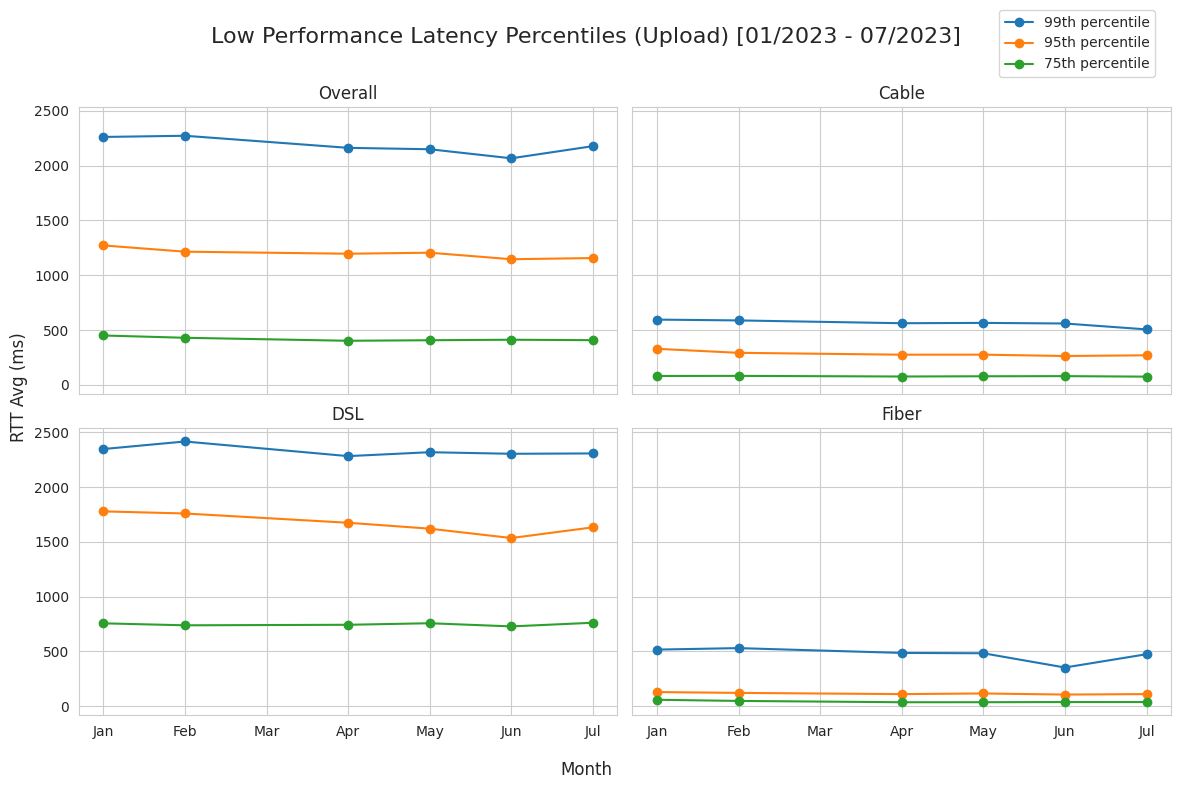

In [8]:
plot_rtt_percentiles_jan_to_jul(up_lat, 'upload')